In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
from datatools import wfip2
from datatools.remote_sensing import ESRL_wind_profiler, Vaisala_CL31

# Compare PBL height (mixing height) observations
also see previous analysis: `~/WFIP2/PBL_characterization_2016-11-21`

## read radar.z04.b0 data
Radar • ESRL Wind Profiler with RASS, Wasco Airport • Reviewed Data

45.59011, -120.67193

Averaged at interval of 60 minutes at the *start* of the bin

In [3]:
elev = 456. # [m]

In [4]:
wind = pd.read_csv('data/Wasco_radar_wind.csv',parse_dates=['date_time']).set_index('date_time')
rass = pd.read_csv('data/Wasco_radar_rass.csv',parse_dates=['date_time']).set_index('date_time')

In [5]:
wind.head()

,HT,SPD,DIR,MET_QC,RAD.0,RAD.1,RAD.2,CNT.0,CNT.1,CNT.2,SNR.0,SNR.1,SNR.2,QC.0,QC.1,QC.2
date_time,,,,,,,,,,,,,,,,
2016-02-23 00:00:02,0.081,8.3,273.0,0.0,-0.1,1.4,3.0,9.0,9.0,9.0,8.0,10.0,7.0,0.0,0.0,0.0
2016-02-23 00:00:02,0.138,7.7,277.0,0.0,0.0,1.1,2.9,9.0,9.0,9.0,11.0,11.0,7.0,0.1,0.0,0.0
2016-02-23 00:00:02,0.196,7.9,280.0,0.0,0.0,0.9,3.0,9.0,9.0,9.0,10.0,9.0,10.0,0.2,0.0,0.0
2016-02-23 00:00:02,0.253,8.0,282.0,0.0,0.0,0.9,3.1,9.0,9.0,9.0,6.0,9.0,12.0,0.2,0.0,0.0
2016-02-23 00:00:02,0.310,7.7,282.0,0.0,0.0,0.9,3.0,9.0,9.0,9.0,1.0,5.0,4.0,0.0,0.0,0.0


In [6]:
rass.head()

,HT,T,Tc,W,QC_T,QC_Tc,QC_W,CNT.0,CNT.1,CNT.2,SNR.0,SNR.1,SNR.2
date_time,,,,,,,,,,,,,
2016-02-23 00:56:49,0.120,7.3,7.0,0.2,0.0,0.0,0.0,15.0,15.0,15.0,14.0,14.0,-10.0
2016-02-23 00:56:49,0.182,6.9,6.6,0.2,0.0,0.0,0.0,15.0,15.0,15.0,15.0,15.0,-6.0
2016-02-23 00:56:49,0.245,6.2,6.1,0.0,0.0,0.0,0.0,15.0,15.0,15.0,5.0,5.0,-4.0
2016-02-23 00:56:49,0.307,5.9,5.6,0.1,0.0,0.0,0.0,15.0,15.0,15.0,-3.0,-3.0,-5.0
2016-02-23 00:56:49,0.370,5.5,5.0,0.3,0.0,0.0,0.0,15.0,15.0,15.0,-12.0,-12.0,-20.0


In [7]:
z = rass['HT'].unique()

## calculate virtual potential temperature
NOAA approach (from Irina Djalalova, 2019-01-31):
- corrected temperature is _not_ used (correction is only for vertical velocity and has no appreciable effect; radio frequency interference and outliers are not accounted for)
- assumes standard atmosphere (http://glossary.ametsoc.org/wiki/Standard_atmosphere)

Equations:

1. Barometric formula for an exponential atmosphere with nonzero lapse rate
$p = p_0 \left[\frac{T_0 - \Gamma(h-h_0)}{T_0}\right]^{1/(\Gamma R/g)}
= p_0 \left[\frac{T_0/\Gamma - h_{asl}}{T_0/\Gamma}\right]^{1/(\Gamma R/g)}$
2. Poisson equation - the relationship between temperature T and pressure p of an ideal gas undergoing an adiabatic process

Notes:
- lapse rate ($\Gamma$) is 6.5$^\circ$C/km, $\Gamma R/g$ = 0.19
- temperature at zero pressure altitude is 15 deg C; $T_0/\Gamma$ = 44331 m
- for one standard atmosphere, $p_0$ = 101,325 Pa; Eqn 1 can also be written
$p = 100\left(\frac{44331-h_{asl}}{11880}\right)^{1/0.19}
= 100\left(1013.25^{0.19}\frac{44331-h_{asl}}{44331}\right)^{1/0.19}
= p_0\left(\frac{44331-h_{asl}}{44331}\right)^{1/0.19}$
- $R/c_p \approx R_d/C_{pd} \approx 287./1004. = 0.286$

In [8]:
rass['P'] = 100.*((44331.514 - (rass['HT']*1000.+elev))/11880.516)**(1./0.1902632)

In [9]:
Pref = 100000. # reference pressure [Pa]
rass['VPT'] = ((rass['T']+273.16)*(Pref/rass['P'])**0.286) # [K]

In [10]:
rass_clean = rass.loc[rass['QC_T']==0]
len(rass),len(rass_clean)

(183175, 74415)

## check Nov 21, 2016

In [11]:
tstart,tend = pd.to_datetime('2016-11-21 17:00'), pd.to_datetime('2016-11-22 05:00')
#datetime_range = (rass.index >= tstart) & (rass.index <= tend)

### first, check potential temperature profile

In [12]:
datetime_range = (rass.index >= tstart-pd.to_timedelta(10,unit='m')) & (rass.index <= tend)
rass_nov21 = rass.loc[datetime_range].pivot(columns='HT',values='VPT')

In [13]:
rass_nov21.head()

HT,0.12,0.182,0.245,0.307,0.37,0.43200000000000005,0.495,0.557,0.619,0.682,...,1.056,1.119,1.181,1.244,1.306,1.369,1.431,1.494,1.556,1.618
date_time,,,,,,,,,,,,,,,,,,,,,
2016-11-21 16:56:59,285.664525,285.866783,286.079324,286.180203,286.495928,286.597249,286.708498,286.912970,287.427985,287.747605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-21 17:56:47,285.766128,285.764964,285.977284,286.180203,286.700890,287.110754,287.223124,287.222410,287.117877,287.436818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-21 18:56:48,286.375740,286.477696,286.691564,286.998270,287.315776,287.521558,287.634825,287.944437,288.254937,288.265584,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-21 19:56:49,285.969332,286.172240,286.181364,285.975686,286.393447,286.597249,286.811424,287.222410,287.221246,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-21 20:56:50,285.969332,286.172240,286.385444,286.486978,286.905852,287.316156,287.634825,288.047584,288.151568,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
len(rass_nov21),rass_nov21.index

(13, DatetimeIndex(['2016-11-21 16:56:59', '2016-11-21 17:56:47',
                '2016-11-21 18:56:48', '2016-11-21 19:56:49',
                '2016-11-21 20:56:50', '2016-11-21 21:56:51',
                '2016-11-21 22:56:51', '2016-11-21 23:56:52',
                '2016-11-22 00:56:53', '2016-11-22 01:56:54',
                '2016-11-22 02:56:55', '2016-11-22 03:56:56',
                '2016-11-22 04:56:57'],
               dtype='datetime64[ns]', name='date_time', freq=None))

In [15]:
tt,zz = np.meshgrid(rass_nov21.index.unique(),z,indexing='ij')

Text(0.5, 1.0, '2016-11-21 to 2016-11-22')

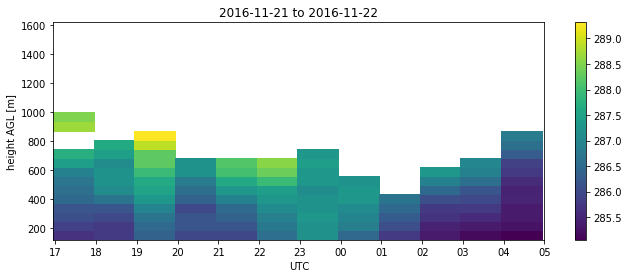

In [16]:
fig,ax = plt.subplots(figsize=(11,4))
pcm = ax.pcolormesh(tt,1000*zz,rass_nov21)
fig.colorbar(pcm)
ax.set_xlabel('UTC')
ax.set_ylabel('height AGL [m]')

ax.set_xticks(pd.date_range(tstart,tend,freq='H'))#, minor=True)
ax.xaxis.set_major_locator(mdates.HourLocator())
#ax.xaxis.set_major_locator(mdates.DayLocator())
#ax.xaxis.set_minor_locator(mdates.HourLocator())
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-$b-%y'))
#ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.set_title('{:s} to {:s}'.format(str(tstart.date()),str(tend.date())))

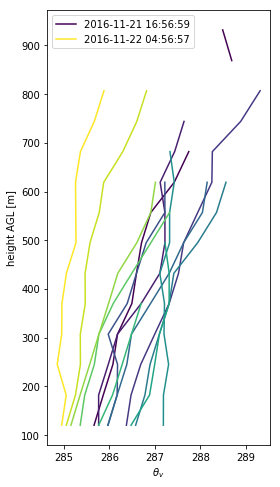

In [17]:
fig,ax = plt.subplots(figsize=(4,8))
cm = get_cmap('viridis')
Tperiod = (rass_nov21.index[-1] - rass_nov21.index[0]).total_seconds()
for ti,row in rass_nov21.iterrows():
    tfrac = (ti - rass_nov21.index[0]).total_seconds() / Tperiod
    if (tfrac==0) or (tfrac==1):
        label = str(ti)
    else:
        label = ''
    ax.plot(row.values,1000*row.index,color=cm(tfrac),label=label)
ax.set_xlabel(r'$\theta_v$')
ax.set_ylabel('height AGL [m]')
ax.legend()

### check signal-to-noise

In [18]:
datetime_range = (wind.index >= tstart) & (wind.index <= tend)
snr0_nov21 = wind.loc[datetime_range].pivot(columns='HT',values='SNR.0')
snr1_nov21 = wind.loc[datetime_range].pivot(columns='HT',values='SNR.1')
snr2_nov21 = wind.loc[datetime_range].pivot(columns='HT',values='SNR.2')

In [19]:
len(snr0_nov21),snr0_nov21.index

(12, DatetimeIndex(['2016-11-21 17:00:01', '2016-11-21 18:00:02',
                '2016-11-21 19:00:02', '2016-11-21 20:00:03',
                '2016-11-21 21:00:04', '2016-11-21 22:00:05',
                '2016-11-21 23:00:06', '2016-11-22 00:00:07',
                '2016-11-22 01:00:08', '2016-11-22 02:00:08',
                '2016-11-22 03:00:09', '2016-11-22 04:00:10'],
               dtype='datetime64[ns]', name='date_time', freq=None))

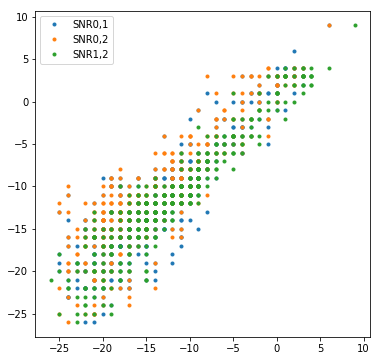

In [20]:
fig,ax = plt.subplots(figsize=(6,6))
ax.plot(snr0_nov21.values.ravel(),snr1_nov21.values.ravel(),'.',label='SNR0,1')
ax.plot(snr0_nov21.values.ravel(),snr2_nov21.values.ravel(),'.',label='SNR0,2')
ax.plot(snr1_nov21.values.ravel(),snr2_nov21.values.ravel(),'.',label='SNR1,2')
ax.legend()

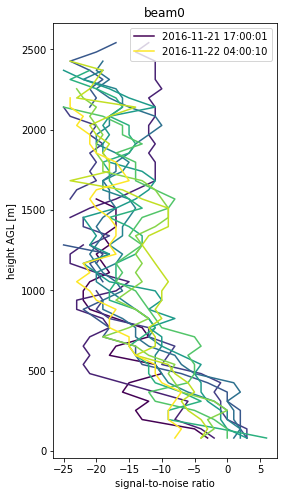

In [21]:
fig,ax = plt.subplots(figsize=(4,8))
cm = get_cmap('viridis')
Tperiod = (snr0_nov21.index[-1] - snr0_nov21.index[0]).total_seconds()
for ti,row in snr0_nov21.iterrows():
    tfrac = (ti - snr0_nov21.index[0]).total_seconds() / Tperiod
    if (tfrac==0) or (tfrac==1):
        label = str(ti)
    else:
        label = ''
    ax.plot(row.values,1000*row.index,color=cm(tfrac),label=label)
ax.set_xlabel(r'signal-to-noise ratio')
ax.set_ylabel('height AGL [m]')
ax.set_title('beam0')
ax.legend()

In [22]:
snr_nov21 = (snr0_nov21 + snr1_nov21 + snr2_nov21)/3

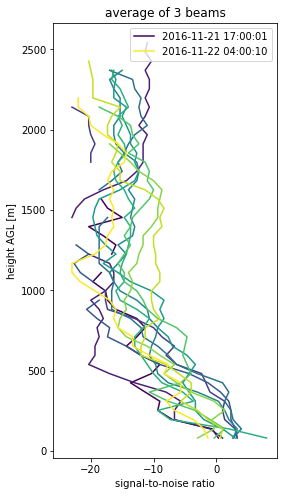

In [23]:
fig,ax = plt.subplots(figsize=(4,8))
cm = get_cmap('viridis')
Tperiod = (snr_nov21.index[-1] - snr_nov21.index[0]).total_seconds()
for ti,row in snr_nov21.iterrows():
    tfrac = (ti - snr_nov21.index[0]).total_seconds() / Tperiod
    if (tfrac==0) or (tfrac==1):
        label = str(ti)
    else:
        label = ''
    ax.plot(row.values,1000*row.index,color=cm(tfrac),label=label)
ax.set_xlabel(r'signal-to-noise ratio')
ax.set_ylabel('height AGL [m]')
ax.set_title('average of 3 beams')
ax.legend()

### read ceilometer data for comparison

In [24]:
ceilo = pd.read_csv('data/Wasco_ceilometer.csv',parse_dates=['date_time']).set_index('date_time')

In [25]:
# throw out unused cloud info
ceilo = ceilo.drop(columns=['Status','Height1','Height2','Height3'])

In [26]:
# reshape data 
ceilo = ceilo.stack().reset_index(1).rename(columns={'level_1':'height',0:'backscat'})

In [27]:
# trim values above say, 2 km or so
ceilo['height'] = ceilo['height'].astype(float)
ceilo = ceilo.loc[ceilo['height'] <= 2500.]
ceilo_heights = ceilo['height'].unique()

In [28]:
# do some averaging
ceilo = ceilo.pivot(columns='height',values='backscat').resample('30min',closed='left').mean()

In [29]:
ceilo

height,0.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0,90.0,...,2410.0,2420.0,2430.0,2440.0,2450.0,2460.0,2470.0,2480.0,2490.0,2500.0
date_time,,,,,,,,,,,,,,,,,,,,,
2016-11-21 00:00:00,36.734513,41.123894,41.522124,41.716814,47.265487,41.646018,38.442478,33.964602,32.283186,29.610619,...,-10.787611,0.628319,-5.362832,2.345133,2.176991,2.699115,-1.079646,-16.548673,-54.115044,-10.044248
2016-11-21 00:30:00,24.178571,26.116071,26.553571,26.383929,32.991071,28.875000,26.375000,24.080357,24.535714,24.276786,...,2.741071,-10.098214,-1.357143,-6.107143,-5.892857,-9.455357,2.839286,-3.562500,-1.366071,5.107143
2016-11-21 01:00:00,25.690265,27.318584,28.044248,28.292035,34.575221,30.486726,28.123894,25.610619,25.672566,24.938053,...,-6.646018,-3.628319,2.946903,-0.451327,36.238938,11.530973,2.752212,8.238938,3.185841,-6.265487
2016-11-21 01:30:00,26.107143,27.544643,28.098214,27.294643,35.857143,30.080357,26.285714,22.964286,22.669643,21.910714,...,16.133929,-8.321429,-11.250000,-19.232143,-28.714286,-20.312500,9.767857,3.508929,9.589286,-2.625000
2016-11-21 02:00:00,27.353982,20.902655,21.584071,21.601770,32.504425,25.840708,21.256637,18.044248,17.743363,17.336283,...,1.017699,-4.814159,-18.690265,-19.318584,-4.238938,22.663717,21.017699,24.991150,10.274336,-13.026549
2016-11-21 02:30:00,29.125000,15.776786,16.008929,16.178571,20.196429,17.669643,16.062500,14.964286,15.589286,15.785714,...,-11.062500,-26.125000,-1.116071,20.401786,1.196429,5.116071,6.901786,16.428571,13.526786,-2.687500
2016-11-21 03:00:00,36.000000,15.893805,15.654867,15.309735,18.991150,17.008850,15.442478,14.522124,15.407080,15.761062,...,14.035398,4.407080,-4.212389,-4.849558,-3.690265,-16.858407,5.292035,-2.849558,4.575221,-17.044248
2016-11-21 03:30:00,45.741071,17.142857,16.107143,16.098214,19.428571,17.491071,16.044643,15.285714,16.214286,16.571429,...,-1.348214,-11.035714,-13.696429,7.455357,5.285714,6.348214,-2.446429,-26.062500,-10.598214,-7.973214
2016-11-21 04:00:00,29.371681,14.743363,14.955752,14.876106,18.584071,16.424779,14.681416,13.778761,14.619469,14.876106,...,2.353982,5.938053,-20.274336,-17.539823,12.539823,-18.743363,-16.707965,11.619469,-2.088496,8.079646


### 1-hr near-neutral period (SciTech 2019 study)

In [30]:
inrange = (wind.index >= '2016-11-21 22:00') & (wind.index <= '2016-11-21 23:15')
signals = ['SNR.0','SNR.1','SNR.2']
heights = 1000 * wind.loc[inrange,'HT'].unique()

Text(0.5, 1.0, 'Radar Wind Profiler')

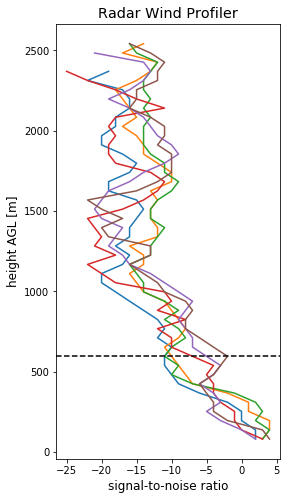

In [31]:
fig,ax = plt.subplots(figsize=(4,8))
df0 = wind.loc[inrange,signals]
for t in df0.index.unique():
    for sig in signals:
        ax.plot(df0.loc[df0.index==t,sig],heights)
ax.axhline(600,color='k',ls='--')
ax.set_xlabel(r'signal-to-noise ratio',fontsize='large')
ax.set_ylabel('height AGL [m]',fontsize='large')
ax.set_title('Radar Wind Profiler',fontsize='x-large')

In [32]:
ceilo_inrange = (ceilo.index >= '2016-11-21 22:00') & (ceilo.index <= '2016-11-21 23:00')

Text(0.5, 1.0, 'Ceilometer')

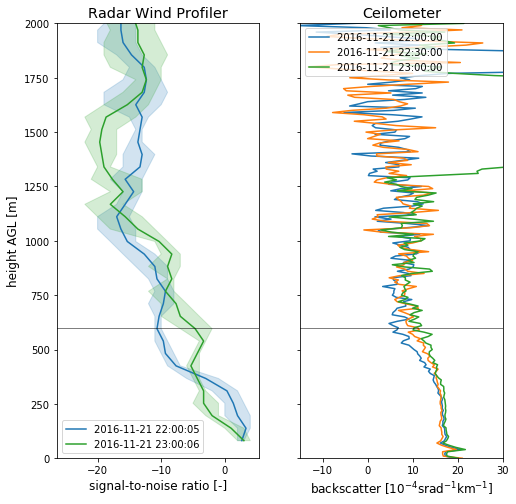

In [33]:
fig,ax = plt.subplots(figsize=(8,8),ncols=2,sharey=True)
df0 = wind.loc[inrange,signals]
colorlist = [colors[i] for i in (0,2)]
for itime,t in enumerate(df0.index.unique()):
    df = df0.loc[df0.index==t]
    color = colorlist[itime]
    ax[0].plot(df.mean(axis=1),heights,color=color,label=str(t))
    ax[0].fill_betweenx(heights,df.min(axis=1),df.max(axis=1),color=color,alpha=0.2)
ax[0].axhline(600,color='k',lw=1,alpha=0.5)
ax[0].set_ylim((0,2000))
ax[0].legend()
ax[0].set_ylabel('height AGL [m]',fontsize='large')
ax[0].set_xlabel('signal-to-noise ratio [-]',fontsize='large')
ax[0].set_title('Radar Wind Profiler',fontsize='x-large')

df = ceilo.loc[ceilo_inrange]
for itime,(t,rowdata) in enumerate(df.iterrows()):
    ax[1].plot(rowdata,ceilo_heights,color=colors[itime],label=str(t))
ax[1].axhline(600,color='k',lw=1,alpha=0.5)
ax[1].set_xlim((-15,30))
ax[1].legend()
ax[1].set_xlabel(r'backscatter [10$^{-4}$srad$^{-1}$km$^{-1}$]',fontsize='large')
ax[1].set_title('Ceilometer',fontsize='x-large')

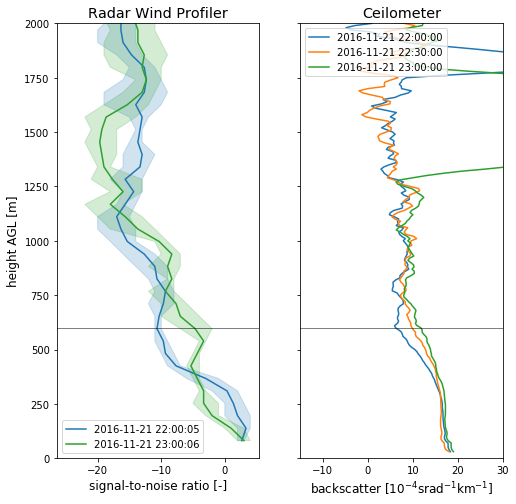

In [34]:
# backscatter profile filtered to radar resolution (~60 m ==> 6 pts w/ 10-m spacing)
N = 6
fltr = np.ones((N,)) / N

fig,ax = plt.subplots(figsize=(8,8),ncols=2,sharey=True)
df0 = wind.loc[inrange,signals]
colorlist = [colors[i] for i in (0,2)]
for itime,t in enumerate(df0.index.unique()):
    df = df0.loc[df0.index==t]
    color = colorlist[itime]
    ax[0].plot(df.mean(axis=1),heights,color=color,label=str(t))
    ax[0].fill_betweenx(heights,df.min(axis=1),df.max(axis=1),color=color,alpha=0.2)
ax[0].axhline(600,color='k',lw=1,alpha=0.5)
ax[0].set_ylim((0,2000))
ax[0].legend()
ax[0].set_ylabel('height AGL [m]',fontsize='large')
ax[0].set_xlabel('signal-to-noise ratio [-]',fontsize='large')
ax[0].set_title('Radar Wind Profiler',fontsize='x-large')

df = ceilo.loc[ceilo_inrange]
zvals = ceilo_heights[int(N/2):-int(N/2)+1]
for itime,(t,rowdata) in enumerate(df.iterrows()):
    #ax[1].plot(rowdata,ceilo_heights,color=colors[itime],label=str(t))
    bs_filtered = np.convolve(rowdata,fltr,mode='valid)')
    ax[1].plot(bs_filtered,zvals,color=colors[itime],label=str(t))
ax[1].axhline(600,color='k',lw=1,alpha=0.5)
ax[1].set_xlim((-15,30))
ax[1].legend()
ax[1].set_xlabel(r'backscatter [10$^{-4}$srad$^{-1}$km$^{-1}$]',fontsize='large')
ax[1].set_title('Ceilometer',fontsize='x-large')
fig.savefig('figures/Wasco_PBL_height_20161121_22Z.png',dpi=150,bbox_inches='tight')